# Titanic classification model

Using StatQuest video on decision forests: clustering for missing data, n optimization, etc

(video 1)[https://youtu.be/J4Wdy0Wc_xQ?si=L08xHb3JQvmHEHjj]

(video 2)[https://youtu.be/sQ870aTKqiM?si=tXDFxqsgornauspB]

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Figures inline and set visualization style
%matplotlib inline
sns.set_theme()

In [36]:
train_data = pd.read_csv("./train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
test_data = pd.read_csv("./test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
summary = pd.DataFrame({
    'Column Type': train_data.dtypes,
    'Missing Values': train_data.isnull().sum(),
    'Total': train_data.count(),
    'Uniques': train_data.nunique(),
    'min': train_data.min(numeric_only=True),
    'mean': train_data.mean(numeric_only=True),
    'median': train_data.median(numeric_only=True),
    'max': train_data.max(numeric_only=True)
}).reset_index().rename(columns={'index': 'Column'})

print("Train data summary:\n")
display(summary)

Train data summary:



,Column,Column Type,Missing Values,Total,Uniques,min,mean,median,max
0,Age,float64,177,714,88,0.42,29.699118,28.0000,80.0000
1,Cabin,object,687,204,147,NaN,NaN,NaN,NaN
2,Embarked,object,2,889,3,NaN,NaN,NaN,NaN
3,Fare,float64,0,891,248,0.00,32.204208,14.4542,512.3292
4,Name,object,0,891,891,NaN,NaN,NaN,NaN
5,Parch,int64,0,891,7,0.00,0.381594,0.0000,6.0000
6,PassengerId,int64,0,891,891,1.00,446.000000,446.0000,891.0000
7,Pclass,int64,0,891,3,1.00,2.308642,3.0000,3.0000
8,Sex,object,0,891,2,NaN,NaN,NaN,NaN
9,SibSp,int64,0,891,7,0.00,0.523008,0.0000,8.0000


Based on above, filling Cabin nan's with an empty string 

In [6]:
summary = pd.DataFrame({
    'Column Type': test_data.dtypes,
    'Missing Values': test_data.isnull().sum(),
    'Total': test_data.count(),
    'Uniques': test_data.nunique(),
    'min': test_data.min(numeric_only=True),
    'mean': test_data.mean(numeric_only=True),
    'median': test_data.median(numeric_only=True),
    'max': test_data.max(numeric_only=True)
}).reset_index().rename(columns={'index': 'Column'})

print("Test data summary:\n")
display(summary)

Test data summary:



,Column,Column Type,Missing Values,Total,Uniques,min,mean,median,max
0,Age,float64,86,332,79,0.17,30.272590,27.0000,76.0000
1,Cabin,object,327,91,76,NaN,NaN,NaN,NaN
2,Embarked,object,0,418,3,NaN,NaN,NaN,NaN
3,Fare,float64,1,417,169,0.00,35.627188,14.4542,512.3292
4,Name,object,0,418,418,NaN,NaN,NaN,NaN
5,Parch,int64,0,418,8,0.00,0.392344,0.0000,9.0000
6,PassengerId,int64,0,418,418,892.00,1100.500000,1100.5000,1309.0000
7,Pclass,int64,0,418,3,1.00,2.265550,3.0000,3.0000
8,Sex,object,0,418,2,NaN,NaN,NaN,NaN
9,SibSp,int64,0,418,7,0.00,0.447368,0.0000,8.0000


#### Notes:
* Majority of Cabin values are Nulls
* About 25% of both test and train having Null Age
* 2 rows with Null Embarked in train
* 1 row with Null Fare in test
* The Tickets are not unique for each person, and they could pontetially encode where the person was seated: based on the last code cell in "Misc" this is probably not true. 
    * We could create analytical columns from Tickets, like if they contain a letter, how many characters they are, if they contain a space, etc.


In [38]:
# Encoding
train_data['Sex'] = train_data['Sex'].map({'female':0,'male':1})
train_data['Embarked'] = train_data['Embarked'].map({'C':0, 'Q':1, 'S':2})
test_data['Sex'] = test_data['Sex'].map({'female':0,'male':1})
test_data['Embarked'] = test_data['Embarked'].map({'C':0, 'Q':1, 'S':2})


Passenger Class vs Survival Distribution:
----------------------------------------
Survived    0    1  Total  Survival Rate (%)
Pclass                                      
1          80  136    216               63.0
2          97   87    184               47.3
3         372  119    491               24.2


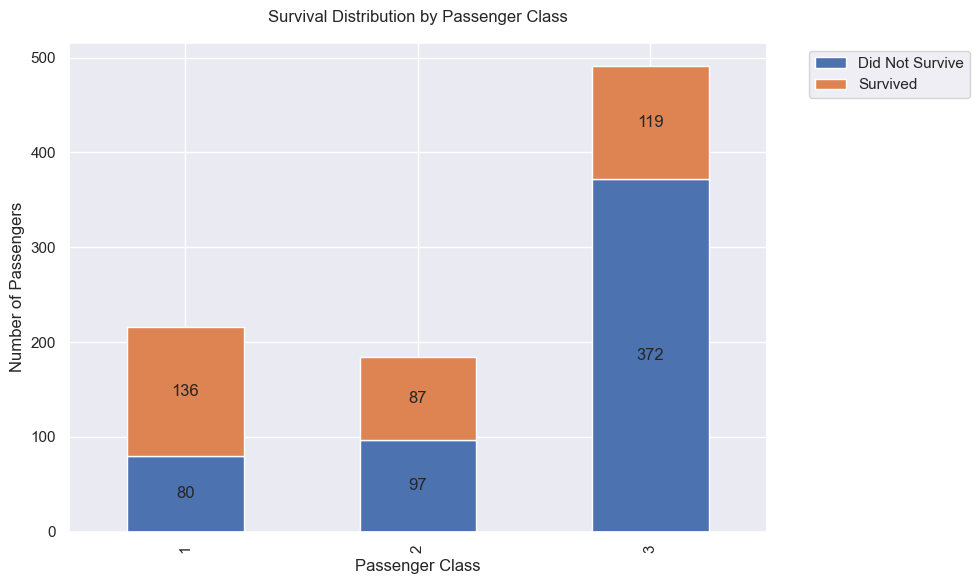

In [12]:
# Create a crosstab of Pclass vs Survived
pclass_survival = pd.crosstab(train_data['Pclass'], train_data['Survived'])

# Add row totals
pclass_survival['Total'] = pclass_survival.sum(axis=1)

# Add survival rates
pclass_survival['Survival Rate (%)'] = (pclass_survival[1] / pclass_survival['Total'] * 100).round(1)

# Display the table
print("\nPassenger Class vs Survival Distribution:")
print("----------------------------------------")
print(pclass_survival)

# Create the stacked bar plot
ax = pclass_survival[[0, 1]].plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Survival Distribution by Passenger Class', pad=15)
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')

# Add legend
plt.legend(['Did Not Survive', 'Survived'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

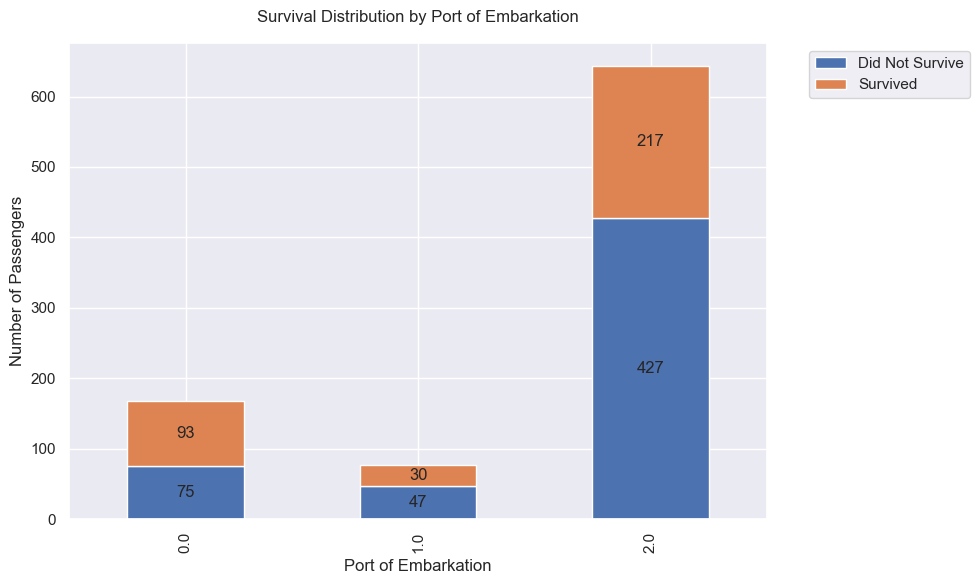

In [13]:
# Create a crosstab of Embarked vs Survived
embarked_survival = pd.crosstab(train_data['Embarked'], train_data['Survived'])

# Add row totals
embarked_survival['Total'] = embarked_survival.sum(axis=1)

# Add survival rates
embarked_survival['Survival Rate (%)'] = (embarked_survival[1] / embarked_survival['Total'] * 100).round(1)

# Create the stacked bar plot
ax = embarked_survival[[0, 1]].plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot
plt.title('Survival Distribution by Port of Embarkation', pad=15)
plt.xlabel('Port of Embarkation')
plt.ylabel('Number of Passengers')

# Add legend
plt.legend(['Did Not Survive', 'Survived'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## Preprocessing steps

This time using a proximity matrix to fill in the missing values for Age. We will do this iteratively until the values converge, based on [StatQuest](https://youtu.be/sQ870aTKqiM?si=Xh-n61ASeja53fOy)

In [63]:
train_data_MedAge = train_data.copy()
missing_age = train_data_MedAge.Age.isna()
train_data_MedAge['Age'] = train_data_MedAge.Age.fillna(train_data.Age.median())
train_data_MedAge['Fare'] = train_data_MedAge.Fare.fillna(train_data.Fare.median())

The follwing code is from https://stackoverflow.com/a/47907919

In [40]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

In [41]:
features = ['Age', 'Sex', 'Embarked', 'Fare', 'Pclass', 'SibSp', 'Parch']
rf = RandomForestClassifier()
rf.fit(train_data[features], train_data['Survived'])

RandomForestClassifier()

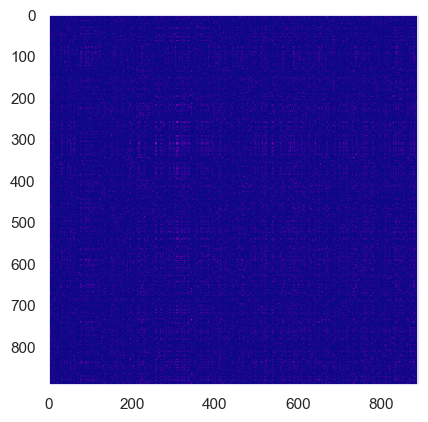

In [42]:
proxmat = proximityMatrix(rf, train_data[features], normalize=True)
np.fill_diagonal(proxmat, 0)

plt.imshow(proxmat, cmap="plasma")
plt.grid(False)
plt.savefig("proxmat1.jpg", dpi=1200)

plt.show()


In [64]:
train_data_latest = train_data_MedAge.copy()
weighted_age = np.dot(np.array(train_data_latest.Age), proxmat[0,:])/proxmat.sum(axis=1)
print(np.round(weighted_age, 1)[missing_age])

[22.6 29.4 64.8 21.3 32.5  7.6  7.  24.6 21.9 29.3  8.3 20.3 24.6 53.1
 50.  68.2 84.4  7.6  8.3 27.4  8.3  8.3  7.6 17.4 40.4  8.3 16.9 44.1
 81.5 10.9 11.7 17.2  7.5 28.6 16.2 22.5 61.5 35.7 41.8 16.9 24.6 17.2
 31.9  7.6 21.5 43.8 78.4 41.8 10.9  6.9 16.9 24.6 54.8 24.6 15.1 29.9
 68.2 67.6 24.6 29.9 21.9  8.3  6.9 17.2 44.   7.2  7.6 42.3 47.7 21.3
 32.5 32.5 20.3 69.9 24.6  6.8  7.6 16.4 21.5  7.6 16.9 15.1 36.  29.3
 10.9 16.9 42.3 15.2 14.5  8.3  7.4 16.9  8.3 15.1 16.4 10.9 37.1 15.1
 21.5 14.5 33.  13.2 64.3 61.1  8.3 20.1 21.3 21.9 43.2 21.9 54.9 13.2
 72.6 16.2 44.6 16.9  8.3 36.  21.9 24.6 81.7 30.4  8.3 62.8 10.4 21.3
  7.6 35.7 12.6 41.8 16.9 16.1 19.4 14.7 61.7 11.1  7.6 32.7  7.6 17.4
  7.4 15.1 75.9 61.7 33.6 84.4 61.1 20.  34.8 15.1  7.6  7.6 74.7 13.2
 44.8 19.5 21.3 16.9 16.1 18.1 16.9 22.5 58.  19.4 17.1 61.7 16.9 21.9
  8.3 78.4 17.2  6.8 21.9 22.5 12.4  7.6 31.5]


In [68]:
train_data_latest = train_data_MedAge.copy()
for n in range(1,7):
    old_age = train_data_latest[missing_age]['Age']
    new_weighted_age = np.dot(np.array(train_data_latest.Age), proxmat)/proxmat.sum(axis=1)
    new_weighted_age = np.round(new_weighted_age, 1)[missing_age]

    print("\nIteration", n)
    print("\nSum of Abs Diff:")
    print(sum(np.abs(old_age - new_weighted_age)))

    train_data_latest['Age'][missing_age] = np.round(new_weighted_age, 1)[missing_age]
    rf = RandomForestClassifier()
    rf.fit(train_data_latest[features], train_data_latest['Survived'])
    proxmat = proximityMatrix(rf, train_data_latest[features], normalize=True)
    np.fill_diagonal(proxmat, 0)
    plt.grid(False)
    plt.savefig("proxmat"+str(n)+".jpg", dpi=1200)

print(train_data_latest[missing_age].Age)


Iteration 1

Sum of Abs Diff:
354.7000000000003


IndexError: boolean index did not match indexed array along dimension 0; dimension is 177 but corresponding boolean dimension is 891

#### Preprocessing test data
Not using the test data itself for any nan replacements

In [8]:
test_data['Age'] = test_data.Age.fillna(28)
test_data['Fare'] = test_data.Fare.fillna(14.4542) # from training data
test_data['Sex'] = test_data['Sex'].map({'female':0,'male':1})
test_data['Embarked'] = test_data['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [9]:
# model.label_classes() # run to confirm order for np.where()
y_pred = rf.predict(test_data[features])

In [10]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_pred})
output.to_csv('submission_sklearn_v1.csv', index=False)

## Results
Score: 0.758

### Misc

In [ ]:
top10tix = train_data['Ticket'].value_counts().head(10)
cabin_groups = train_data[train_data['Ticket'].isin(top10tix.index)].groupby('Cabin').agg({
    'PassengerId': 'count',
    'Survived': ['sum', 'mean'],
    'Pclass': 'first',
    'Ticket': lambda x: ', '.join(x.unique())
}).sort_values(('PassengerId', 'count'), ascending=False).head(10)
print(cabin_groups)